# Analyze & Build Model of Tweets to Predict Party Affiliation
## Data collected during 2016 Election Debates

In [ ]:
import pandas as pd
import nltk
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn import tree
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

In [3]:
tweets = pd.read_csv('tweets_debate1.csv')
users  = pd.read_csv('users.csv')

In [4]:
tweets.head(5)

,userID,text,created_at,favorite_count,followers_account,friends_count,location
0,11344,Police start the presidential debate memes swi...,09/26/2016 21:00:00 EDT,1,123,96,"East Point, GA"
1,2061,"RT @thereaIbanksy: become the most positive, e...",09/26/2016 21:00:03 EDT,481,116,244,"Kansas City, MO USA"
2,22644,This is gonna be a stressful ass week.,09/26/2016 21:00:03 EDT,9930,176,163,"Dundee, Oregon"
3,9694,RT @KevinBracken4: #serviceselfie #T2Trun NY M...,09/26/2016 21:00:12 EDT,8135,235,136,NY Metro
4,9087,RT @HillaryClinton: Let's do this. #DebateNigh...,09/26/2016 21:00:13 EDT,141,70,163,"New York, NY"


In [5]:
users.head(5)

,userID,state_code,party
0,1,AK,D
1,2,AK,D
2,3,AL,NaN
3,4,AL,NaN
4,5,AL,NaN


### Merge datasets on userID to add party code

In [19]:
df = pd.merge(tweets, users, on='userID')
df.head(5)

,userID,text,created_at,favorite_count,followers_account,friends_count,location,state_code,party
0,11344,Police start the presidential debate memes swi...,09/26/2016 21:00:00 EDT,1,123,96,"East Point, GA",GA,NaN
1,11344,Are these the new Pixel Phone and Chromecast c...,09/26/2016 22:30:00 EDT,1,123,96,"East Point, GA",GA,NaN
2,11344,Are these the new Pixel Phone and Chromecast c...,09/26/2016 22:30:00 EDT,1,127,96,"East Point, GA",GA,NaN
3,11344,Police start the presidential debate memes swi...,09/26/2016 21:00:00 EDT,1,127,96,"East Point, GA",GA,NaN
4,2061,"RT @thereaIbanksy: become the most positive, e...",09/26/2016 21:00:03 EDT,481,116,244,"Kansas City, MO USA",MO,NaN


In [17]:
df.shape

(23247, 9)

### Drop NAs

## Examine class Distribution

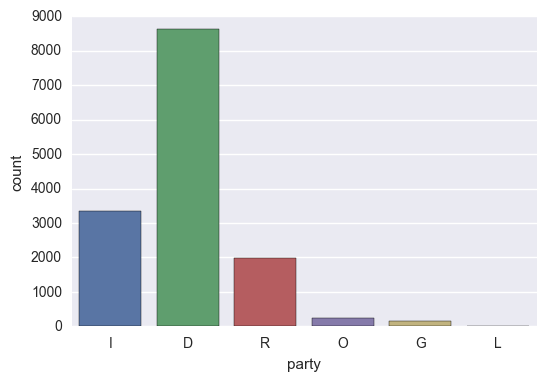

In [8]:
%matplotlib inline
sns.countplot(x="party", data=df)

## Preprocess Data

In [ ]:
def remove_stops(obs):
    stops = set(stopwords.words('english'))
    tokens = obs.apply(lambda x: [item for item in x if item not in stops])
    return tokens


def normalize(df, remove_stopwords=True):
    obs = df.text.str.lower()
    obs = obs.str.strip()
    obs = obs.str.strip('""')
    obs = obs.apply(nltk.word_tokenize)

    if (remove_stopwords):
        obs = remove_stops(obs)

    obs = obs.str.join(' ')
    df['X'] = obs
    return obs

## Create Text Features

In [11]:
### DTM
def getDTM(features):
    vect = CountVectorizer()
    dtm = vect.fit_transform(features)
    return dtm
### DTM BI, Tri grams
def featuresByBagOfWordsBiTri(features):
    vect = CountVectorizer(ngram_range=(2, 3))
    dtm = vect.fit_transform(features)
    return dtm
### TF-IDF
def getDTMByTFIDF(features,nfeatures):
    tfIdf_vectorizer = TfidfVectorizer(max_features=nfeatures)
    dtm = tfIdf_vectorizer.fit_transform(features).toarray()
    return dtm,tfIdf_vectorizer
### Information Gain
def featuresByInformationGain(features,labels):
    treeCL = tree.DecisionTreeClassifier(criterion="entropy")
    treeCL = treeCL.fit(features,labels)
    transformed_features = SelectFromModel(treeCL,prefit=True).transform(features)
    return transformed_features
### Chi Squared
def featuresByChiSq(features,labels,nFeature=5000):
    chi2_model = SelectKBest(chi2,k=nFeature)
    dtm = chi2_model.fit_transform(features,labels)
    return dtm,chi2_model
### LSA
def featuresByLSA(features,ncomponents=100):
    svd = TruncatedSVD(n_components=ncomponents)
    normalizer =  Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    dtm_lsa = lsa.fit_transform(features)
    return dtm_lsa
### NMF

### Feature Selection

In [14]:
dtm = getDTM(df['text'])
bitriDtm = featuresByBagOfWordsBiTri(df['text'])
tfidfDtm, vect = getDTMByTFIDF(df['text'], None)

# the Information Gain, Chi Squared, & LSA features selection need a DTM
chisqDtm, chisqModel = featuresByChiSq(dtm,df['party'],2000)
#igDtm = featuresByInformationGain(dtm,labels)
#lsaDtm = featuresByLSA(dtm,100)


ValueError: Unknown label type: (array([nan, nan, nan, ..., 'D', 'D', 'D'], dtype=object),)

## Model

In [ ]:
def crossValidate(document_term_matrix,labels,classifier="SVM",nfold=2):
    clf = None
    precision = []
    recall = []
    fscore = []
    
    if classifier == "RF":
        clf = RandomForestClassifier()
    elif classifier == "NB":
        clf = MultinomialNB()
    elif classifier == "SVM":
        clf = LinearSVC()
    
    skf = StratifiedKFold(labels, n_folds=nfold)

    for train_index, test_index in skf:
        X_train, X_test = document_term_matrix[train_index], document_term_matrix[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        p,r,f,s = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        precision.append(p)
        recall.append(r)
        fscore.append(f)
        
    return np.mean(precision),np.mean(recall),np.mean(fscore)

In [ ]:
al